## Стельмах Я.С. ИУ5-21М

Вариант 9

- 1 класс = номер группы + 11 = 21 + 11 = 32 (elephant, слон)
- 2 класс = номер варианта + 37 = 9 + 37 = 46 (lobster, лобстер)
- 3 класс = номер варианта + 42 = 9 + 42 = 51 (mouse, мышь)


In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# X = (np.arange(100)/100 - 0.5).repeat(5)
# tensor_X = (X.reshape(-1, 1))
# # tensor_X = torch.Tensor(X.reshape(-1, 1))
# tensor_X

# X = np.random.randint(2, size=(1000, 2))
# X
# X.shape
# X.reshape(-1, 2)

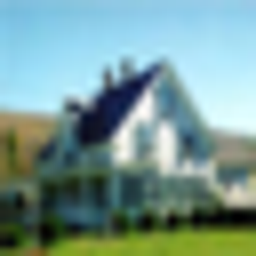

In [3]:
with open('data/cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('data/cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

CLASSES = [32, 46, 51]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

In [4]:
# batch_size = 128
# batch_size = 10
batch_size = 200
# batch_size = 500

# EPOCHS = 250
EPOCHS = 119
# EPOCHS = 10

HIDDEN_SIZE = 50

LR = 0.005

In [5]:
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x227f2822fd0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x227f2820190>}

In [6]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

In [8]:

steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
test_precision = []
train_precision = []
losses = []

for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / steps_per_epoch:.3f}')
    losses.append(running_loss)


    train_precision.append(1 - (running_loss / steps_per_epoch))
    
    
    running_loss = 0.0
    model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] val loss: {running_loss / steps_per_epoch_val:.3f}')


    test_precision.append(1 - (running_loss / steps_per_epoch_val))

min_loss = 1e5
min_loss_idx = -1
for i in range(1, EPOCHS):
    if min_loss > losses[i]:
        min_loss = losses[i]
        min_loss_idx = i
print('Обучение закончено. Мин значение функции потерь', np.min(losses), 'на', min_loss_idx + 1, 'эпохе')


[1,     8] loss: 1.093
[1,     2] val loss: 1.057
[2,     8] loss: 1.027
[2,     2] val loss: 0.987
[3,     8] loss: 0.967
[3,     2] val loss: 0.931
[4,     8] loss: 0.918
[4,     2] val loss: 0.882
[5,     8] loss: 0.872
[5,     2] val loss: 0.842
[6,     8] loss: 0.837
[6,     2] val loss: 0.814
[7,     8] loss: 0.817
[7,     2] val loss: 0.781
[8,     8] loss: 0.790
[8,     2] val loss: 0.775
[9,     8] loss: 0.766
[9,     2] val loss: 0.739
[10,     8] loss: 0.755
[10,     2] val loss: 0.728
[11,     8] loss: 0.739
[11,     2] val loss: 0.704
[12,     8] loss: 0.715
[12,     2] val loss: 0.708
[13,     8] loss: 0.707
[13,     2] val loss: 0.685
[14,     8] loss: 0.708
[14,     2] val loss: 0.672
[15,     8] loss: 0.691
[15,     2] val loss: 0.676
[16,     8] loss: 0.675
[16,     2] val loss: 0.662
[17,     8] loss: 0.667
[17,     2] val loss: 0.643
[18,     8] loss: 0.655
[18,     2] val loss: 0.609
[19,     8] loss: 0.646
[19,     2] val loss: 0.635
[20,     8] loss: 0.634
[20,  

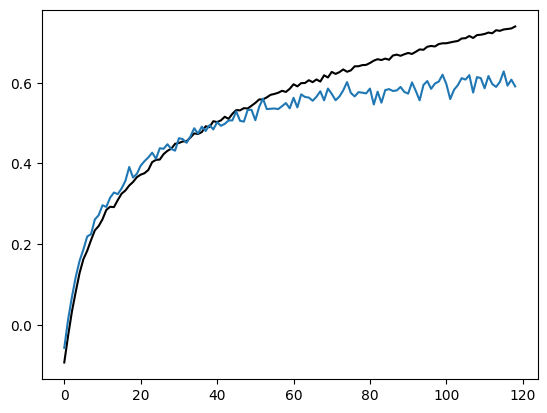

In [9]:
plt.plot(train_precision, color = 'black')
plt.plot(test_precision)


In [10]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

          37     0.9137    0.9100    0.9118       500
          63     0.9294    0.9220    0.9257       500
          28     0.8953    0.9060    0.9006       500

    accuracy                         0.9127      1500
   macro avg     0.9128    0.9127    0.9127      1500
weighted avg     0.9128    0.9127    0.9127      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

          37     0.8485    0.8400    0.8442       100
          63     0.8558    0.8900    0.8725       100
          28     0.8557    0.8300    0.8426       100

    accuracy                         0.8533       300
   macro avg     0.8533    0.8533    0.8531       300
weighted avg     0.8533    0.8533    0.8531       300

--------------------------------------------------


In [11]:
# fig = plt.figure(figsize=(10, 10))
# columns = 8
# rows = 8
# for i in range(1, columns*rows +1):
#     img = Image.fromarray(train_X[i]).resize((256,256))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
# plt.show()


In [12]:
# weights = list(model.parameters())[0].detach().numpy()
# print(weights.shape)
# fig, ax = plt.subplots(1, weights.shape[0], figsize=(3*weights.shape[0], 3))
# for i, ω in enumerate(weights):
#     ω = ω.reshape(32, 32, 3)
#     ω -= np.percentile(ω, 1, axis=[0, 1])
#     ω /= np.percentile(ω, 99, axis=[0, 1])
#     ω = np.clip(ω, 0, 1) 
#     ax[i].imshow(ω)

Сохранение в ONNX (см. лаб 2)

In [13]:
# входной тензор для модели
# x = torch.randn(1, 32, 32, 3, requires_grad=True)
# torch_out = model(x)

# # экспорт модели
# torch.onnx.export(model,               # модель
#                   x,                   # входной тензор (или кортеж нескольких тензоров)
#                   "output models lab1/cifar100_CNN.onnx", # куда сохранить (либо путь к файлу либо fileObject)
#                   export_params=True,  # сохраняет веса обученных параметров внутри файла модели
#                   opset_version=9,     # версия ONNX
#                   do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
#                   input_names = ['input'],   # имя входного слоя
#                   output_names = ['output'],  # имя выходного слоя
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
#                                 'output' : {0 : 'batch_size'}})